# Deep Meow : Labeling the emission context of cat meows

The goal of this deep learning model is to identify the context in which a cat meows. For this purpose, we use a dataset of 440 meows from 21 cats (two breeds: Maine Coon and European Shorthair), recorded under three eliciting contexts: Brushing, Isolation in an unfamiliar environment, and Waiting for food. Each stimulus lasted up to 5 minutes and recordings were collected in naturalistic settings with standardized handling to minimize stress.
This dataset is provided by the university of Milan at this address : [CatMeows: A Publicly-Available Dataset of Cat Vocalizations](https://zenodo.org/records/4008297).
We also based our research on this paper : [Audio Deep Learning : Sound Classification](https://medium.com/data-science/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5)

## Imports

### 4 types of libraries:

- Google Colab — to import our dataset directly from the environment
- System and utility tools (zip, os, math)
- Data handling (pandas, torch)
- Audio and PyTorch utilities (torchaudio, torch.utils)

In [2]:
from google.colab import files

import zipfile
import os
import math, random

import pandas as pd
import torch
import torchaudio

from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

## Dataset import in the zip format

In [3]:
# file uploading
uploaded = files.upload()

# file unzipping
with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("dataset_audio")

# check the content after unzipping
print(f'number of audios: {len(os.listdir("dataset_audio/dataset"))}')

Saving dataset.zip to dataset.zip
number of audios: 440


## Creation of a joined metadata dataset

In [4]:
# Data Loading and Preprocessing

# Connection to dataset path
data_path = "dataset_audio/dataset"

rows = []
for file in os.listdir(data_path):
    if file.endswith(".wav"):
        class_letter = file[0]  # first letter is the class
        relative_path = f"/{file}"
        rows.append({"relative_path": relative_path, "class": class_letter})

df = pd.DataFrame(rows)

# Map letters to integers to get emission context class
class_map = {c: i for i, c in enumerate(sorted(df["class"].unique()))}
df["classID"] = df["class"].map(class_map)

print("Class mapping:", class_map)
print(df.head())


Class mapping: {'B': 0, 'F': 1, 'I': 2}
                  relative_path class  classID
0  /F_MAG01_EU_FN_FED01_305.wav     F        1
1  /F_SPI01_EU_MN_NAI01_202.wav     F        1
2  /I_CLE01_EU_FN_FER01_107.wav     I        2
3  /F_SPI01_EU_MN_NAI01_301.wav     F        1
4  /I_CLE01_EU_FN_FER01_105.wav     I        2


We now have emission context for each audio where B is brushing; F is waiting for food; I is isolation in an unfamiliar environment.

## Audio transformation into a Mel spectrogram

We created a class AudioUtil to perform multiple operation on each of our audio in order to prepare them for our machine learning modeling. The breakdown of this class is as follows :
- **open(audio_file)** load the audio when given its path. It returns the audio signal as a PyTorch tensor and its sample rate.
- **rechannel(aud, new_channel)** adjust the number of audio channels. If the audio is in stereo it duplicates it select the first channel and apply it in both channel. If the audio is in mono, it duplicate the audio in the first channel into the second channel. If there is a multi-channel audio then it resample each channel. Here we ensure each signal is in stereo.
- **pad_trunc(aud, max_ms)** ensure all the audio signal have a consistent max_length in milliseconds. We went with 4000 ms, so if the audio is longer than 4 seconds it truncates the end, and if the audio is shorter than 4 seconds then it fills the audio with 0 noise at the begininng and at the end.
- **time_shift(aud, shift_limit)** is a data augmentation technique were the signal is shifted by a random percentage up to the shift limit , wrapping arround the signal length.
- **spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)** is were we generate our Mel spectrogram based on our raw audio signal. A Mel spectrogram is a visual representation of the spectrum of frequencies of a sound as they vary with time, on a Mel scale. What it does ultimately is convert the audio into an image.4


In [5]:
# Creation of the AudioUtil class
class AudioUtil():

  # load of the audio file
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  # convert the audio into desired number of channel
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    # if signal shape is same as number of channel we keep it as is
    if (sig.shape[0] == new_channel):
      return aud

    # if audio is in stereo and want mono we keep the first channel only
    if (new_channel == 1):
      resig = sig[:1, :]
    #  the other way round if audio is in mono by duplicating the first channel
    else:
      resig = torch.cat([sig, sig])
    return ((resig, sr))


  # Since Resample applies to a single channel, we resample one channel at a time
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    # Nothing to do
    if (sr == newsr):
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # Pad/Truncate the signal to a fixed length 'max_ms' in milliseconds

  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)

    return (sig, sr)


  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)


  # Generate a Mel spectrogram
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], we give sr as stereo
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)



  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec



## Audio preparation for Deep Learning

This SoundDS class serves as a custom PyTorch Dataset, designed to load and preprocess the audio files. It inherits from torch.utils.data.Dataset, making it compatible with PyTorch's data loading utilities like DataLoader.

In [6]:
# Sound dataset Class compatible with PyTorch
class SoundDS(Dataset):
  def __init__(self, df, data_path):
  # parameters we used for our audio standardization
    self.df = df
    self.data_path = str(data_path)
    self.duration = 3000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4

  # get the number of files in the dataset class
  def __len__(self):
    return len(self.df)


  # get to the i'th item in dataset
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with the relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']

    # Get the class ID
    class_id = self.df.loc[idx, 'classID']

    # All audio files were resampled to a uniform sample rate and converted to a consistent channel configuration (mono/stereo)
    # then we guarantee consistent sample rate for a given duration. We standardized the audio files for our model.
    aud = AudioUtil.open(audio_file)
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)
    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    # Finally we convert label to tensor
    label = torch.tensor(class_id, dtype=torch.long)

    return aug_sgram, class_id

## Splitting the dataset into train, valid and test

We decided to split the dataset following these proportion :
- 80% of the dataset will train our model
- 10% is for the validation subset, to adjust the model
- 10% to test the model

In [24]:
# Dataset splitting
myds = SoundDS(df, data_path)

# Split the dataset into training, validation, and test sets (70% train, 15% val, 15% test)
num_items = len(myds)
num_train = round(num_items * 0.8)
remaining = num_items - num_train
num_val = round(remaining * 0.5)
num_test = remaining - num_val

train_ds, val_ds, test_ds = random_split(myds, [num_train, num_val, num_test])

# Create training, validation and test data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

## Audio classifier : CNN based model architecture

wa based the following architecture on the architecture done on this paper : https://medium.com/data-science/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

with four convolution block and 1 linear classifier

In [25]:
# Audio Classification Model
class AudioClassifier(nn.Module):
    # model architecture
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=3)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

    # Forward pass computations
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Dropout + Linear layer
        x = self.lin(x)

        # Final output
        return x

 ## Model Initialization and Device Setup

In [26]:
# Create the model and put it on the cuda GPU
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
next(myModel.parameters()).device

device(type='cpu')

## Boucle d'apprentissage sur les données

This function trains a neural network model over multiple epochs. It takes as parameters the model to train, the dataloaders (train_dl and val_dl) for training and validation data, and the number of epochs. It uses CrossEntropyLoss as the loss function, the Adam optimizer with a learning rate of 0.0001, and a OneCycleLR scheduler that cyclically varies the learning rate to improve convergence. At each epoch, it iterates through training batches, normalizes the inputs, computes predictions, loss and gradients, then updates the model weights. It tracks performance metrics (loss and accuracy) on both training and validation sets, and returns these histories to allow visualization of the learning progress.

In [27]:
# Training Loop Function
def training(model, train_dl, val_dl, num_epochs):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0005,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Storage of values at the end of each epoch
  train_accuracies = []
  val_accuracies = []
  train_losses = []
  val_losses = []

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    if epoch%10 == 0:
      print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    train_accuracies.append(acc)
    train_losses.append(avg_loss)

    # Evaluate on validation set
    val_acc, val_loss = inference(model, val_dl)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)


  print('Finished Training')
  return train_accuracies, val_accuracies, train_losses, val_losses


## Inference function : accuracy and loss

This chunk of code as part of the training loop, we evaluate our metrics on the validation data. We would then do inference on unseen data, by keeping aside a test dataset from the original data.

In [28]:
# Inference Function
def inference(model, dl):
  correct_prediction = 0
  total_prediction = 0
  running_loss = 0.0
  criterion = nn.CrossEntropyLoss()

  # Disable gradient updates
  with torch.no_grad():
    for data in dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      # Keep stats for Loss and Accuracy
      running_loss += loss.item()

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]

  acc = correct_prediction/total_prediction
  avg_loss = running_loss / len(dl)
  return acc, avg_loss



## Training the model

This step can take quite some time, varying from 20 minutes (if cuda T4 is activated) up to hours on CPU
We fixed the number of epoch to 230 to minimize over fitting as a parameter for our model.

We should find a final accuracy around 70% (+- 5%)

In [30]:
num_epochs=180
train_accs, val_accs, train_losses, val_losses = training(myModel, train_dl, val_dl, num_epochs)
# Run inference on the test set after training
test_acc, test_loss = inference(myModel, test_dl)
print(f'Final Test Accuracy: {test_acc:.2f}, Final Test Loss: {test_loss:.2f}')


Epoch: 0, Loss: 1.13, Accuracy: 0.30
Epoch: 10, Loss: 0.97, Accuracy: 0.57
Epoch: 20, Loss: 0.91, Accuracy: 0.59
Epoch: 30, Loss: 0.85, Accuracy: 0.61
Epoch: 40, Loss: 0.78, Accuracy: 0.64
Epoch: 50, Loss: 0.80, Accuracy: 0.67
Epoch: 60, Loss: 0.75, Accuracy: 0.66
Epoch: 70, Loss: 0.71, Accuracy: 0.68
Epoch: 80, Loss: 0.69, Accuracy: 0.70
Epoch: 90, Loss: 0.70, Accuracy: 0.70
Epoch: 100, Loss: 0.66, Accuracy: 0.72
Epoch: 110, Loss: 0.63, Accuracy: 0.72
Epoch: 120, Loss: 0.61, Accuracy: 0.75
Epoch: 130, Loss: 0.60, Accuracy: 0.74
Epoch: 140, Loss: 0.62, Accuracy: 0.73
Epoch: 150, Loss: 0.60, Accuracy: 0.74
Epoch: 160, Loss: 0.58, Accuracy: 0.77
Epoch: 170, Loss: 0.57, Accuracy: 0.76
Finished Training
Final Test Accuracy: 0.61, Final Test Loss: 0.73


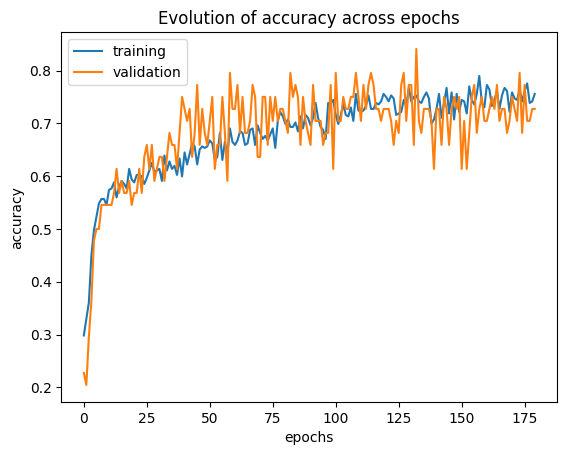

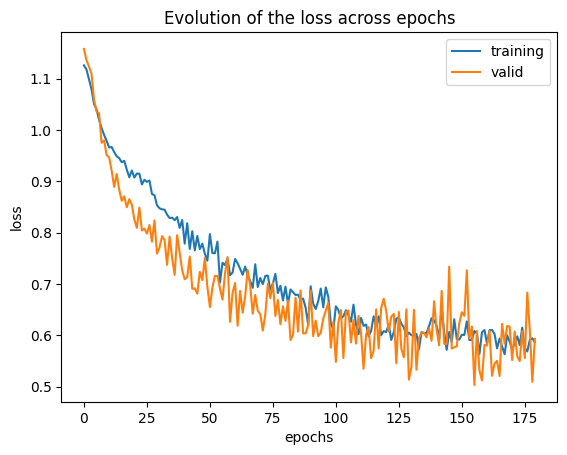

Performance of the final validation iteration is : 0.73
test accuracy (test )0.61, and test loss 0.73


In [32]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(train_accs, label="training")
plt.plot(val_accs, label="validation")
plt.title("Evolution of accuracy across epochs")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_losses, label="training")
plt.plot(val_losses, label="valid")
plt.title("Evolution of the loss across epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# Print the final accuracy
print(f"Performance of the final validation iteration is : {val_accs[-1]:.2f}")

print(f'test accuracy (test ){test_acc:.2f}, and test loss {test_loss:.2f}')